In [1]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import sys
sys.path.append("..")
%cd ..


/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from DataPrep.ImportData import importer
from Modelling import modelling
import keras
from keras import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Reshape
import pyforest
import torch
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error



In [3]:
m = modelling()
df = m.df.drop(columns=["Charging Time (mins)", "Total Duration (mins)", "Port Number"])

In [4]:
cols_to_standardize = ['# Professional & Other Places', '# Food', '# Shop & Service',
       '# Travel & Transport', '# Outdoors & Recreation',
       '# Arts & Entertainment', '# Nightlife Spot', '# Residence',
       '# College & University', '# Event']

In [5]:
sc = StandardScaler()
stand_poi = sc.fit_transform(df[cols_to_standardize])

In [6]:
stand_poi = pd.DataFrame(stand_poi, index=df.index, columns=cols_to_standardize)

In [7]:
for i in cols_to_standardize:
    df[i] = stand_poi[i]

In [8]:
df["Label"] = df["Label"] + 1

In [15]:
#df = df.drop(columns=cols_to_standardize)

In [9]:
df = df.fillna(0)

In [10]:
df["Energy (kWh)"]

0        1.679882
1        1.899242
2        1.574471
3        1.982032
4        2.232860
           ...   
17276    4.018583
17277    4.247111
17278    2.646125
17279    4.348600
17280    3.383808
Name: Energy (kWh), Length: 17281, dtype: float64

In [11]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")


In [12]:
labels = df.Label.unique()

In [13]:
df_reindex = pd.DataFrame()
idx = pd.period_range(min(df.index), max(df.index))
for i in labels:
    filling = df[df.Label == i].reindex(idx, fill_value = 0)
    filling.Label = i
    df_reindex = df_reindex.append(filling)

In [14]:
df = df_reindex.sort_index()

,Label,Energy (kWh),CenterLon,CenterLat,Level 1,Level 2,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,...,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
2011-08-03,1.0,1.679882,-122.160000,37.445,0,8,2.098609,1.260311,2.325573,1.726841,...,0,0,0,1,0,0,0,0,0,0
2011-08-04,1.0,1.899242,-122.160000,37.445,0,5,1.679882,2.098609,1.260311,2.325573,...,0,0,0,1,0,0,0,0,0,0
2011-08-05,1.0,1.574471,-122.160000,37.445,0,10,1.899242,1.679882,2.098609,1.260311,...,0,0,0,1,0,0,0,0,0,0
2011-08-06,1.0,1.982032,-122.160000,37.445,0,14,1.574471,1.899242,1.679882,2.098609,...,0,0,0,1,0,0,0,0,0,1
2011-08-07,1.0,2.232860,-122.160000,37.445,0,3,1.982032,1.574471,1.899242,1.679882,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,8.0,4.018583,-122.143998,37.428,0,15,2.637143,6.296000,3.313000,4.478885,...,0,0,0,0,0,0,0,1,0,0
2019-12-28,8.0,4.247111,-122.143998,37.429,0,7,4.018583,2.637143,6.296000,3.313000,...,0,0,0,0,0,0,0,1,0,1
2019-12-29,8.0,2.646125,-122.143998,37.428,0,11,4.247111,4.018583,2.637143,6.296000,...,0,0,0,0,0,0,0,1,0,1
2019-12-30,8.0,4.348600,-122.143998,37.428,0,19,2.646125,4.247111,4.018583,2.637143,...,0,0,0,0,0,0,0,1,0,0


In [144]:
X = tf.convert_to_tensor(np.array([df.drop(columns=["Energy (kWh)"])[df.Label == i] for i in labels]))
y = tf.convert_to_tensor(np.array([df["Energy (kWh)"][df.Label == i] for i in labels]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [145]:
y = tf.convert_to_tensor(tf.experimental.numpy.diff(y))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [146]:
X = X[:,1:]

In [147]:
X = tf.transpose(X, perm = [1,0,2])

<IPython.core.display.Javascript object>

In [148]:
y = tf.transpose(y)

<IPython.core.display.Javascript object>

In [154]:
X_train_stack, X_val_stack, X_test_stack = tf.split(X, [2212, 240, 3072 - 2212 - 240], 0)
y_train_stack, y_val_stack, y_test_stack = tf.split(y, [2212, 240, 3072 - 2212 - 240], 0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [131]:
X_test_stack.shape

TensorShape([620, 80, 8])

In [177]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

inputs = Input(shape=(None,80))
x = LSTM(68, return_sequences = True, activation = "tanh")(inputs)
x = Dropout(0.2)(x)
x = LSTM(42, return_sequences = True, activation = "tanh")(x)
x = Dropout(0.5)(x)
x = Dense(10, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)


m = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")
#opt = opt = keras.optimizers.Adam(learning_rate=1)
m.compile(optimizer="adam", loss='mse', metrics=["mae"])

history = m.fit(X_train_stack, y_train_stack, epochs=200, batch_size=16, validation_data = (X_val_stack, y_val_stack),callbacks=tensorboard_callback)

Epoch 1/200
139/139 [==============================] - 13s 33ms/step - loss: 0.2714 - mae: 0.2988 - val_loss: 0.6436 - val_mae: 0.5904
Epoch 2/200
139/139 [==============================] - 2s 15ms/step - loss: 0.2434 - mae: 0.2733 - val_loss: 0.6436 - val_mae: 0.5904
Epoch 3/200
139/139 [==============================] - 2s 15ms/step - loss: 0.2525 - mae: 0.2772 - val_loss: 0.6436 - val_mae: 0.5904
Epoch 4/200
139/139 [==============================] - 2s 14ms/step - loss: 0.2435 - mae: 0.2747 - val_loss: 0.6437 - val_mae: 0.5904
Epoch 5/200
139/139 [==============================] - 2s 14ms/step - loss: 0.2450 - mae: 0.2776 - val_loss: 0.6437 - val_mae: 0.5904
Epoch 6/200
139/139 [==============================] - 2s 15ms/step - loss: 0.2480 - mae: 0.2785 - val_loss: 0.6436 - val_mae: 0.5903
Epoch 7/200
139/139 [==============================] - 2s 16ms/step - loss: 0.2512 - mae: 0.2776 - val_loss: 0.6437 - val_mae: 0.5904
Epoch 8/200
139/139 [==============================] - 2s 15m

In [289]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [301]:
def predict(cluster, model):
    s = y_val_stack[:, cluster][y_val_stack[:, cluster] != 0].shape[0]
    y_pred = model.predict(np.array(X_val_stack[:, cluster][y_val_stack[:, cluster] != 0]).reshape(s,1,80)).flatten()
    y_val = np.array(y_val_stack[:, cluster][y_val_stack[:, cluster] != 0]).flatten()
    outstring = f"Cluster: {cluster}\nR^2: {r2_score(y_val,y_pred)}\nRMSE:{np.sqrt(mean_squared_error(y_val,y_pred))}\nMAPE:{mean_absolute_percentage_error(y_val,y_pred)}\n"
    outstring += f"MAE: {mean_absolute_error(y_val,y_pred)}\nsMAPE: {smape(y_val,y_pred)}"
    print(outstring)

    plt.plot(y_val)
    plt.plot(y_pred)
    plt.show()



In [188]:
np.array(m.predict(X_test_stack)).flatten().shape

<IPython.core.display.Javascript object>

(4960,)

In [300]:
y_val_stack[:, 1]

<tf.Tensor: shape=(240,), dtype=float64, numpy=
array([ 3.72044433e-01, -1.86972602e-01,  2.69860302e-01, -1.81894313e-01,
       -2.46425316e-01,  5.16120630e-02,  4.13437573e-01, -7.74292763e-02,
       -1.66742788e-01,  5.00949915e-01, -3.92311539e-01,  5.74563163e-01,
       -2.39290000e-01, -3.89329310e-01, -1.97995690e-01, -2.42291667e-01,
        1.53353991e-01,  6.81163615e-01, -4.17284272e-01,  7.41868116e-01,
       -6.50103278e-01,  9.23557251e-01, -1.83079510e+00,  9.72562123e-01,
        3.55718283e-01,  4.33825939e-01, -7.69672222e-01,  2.65789683e-01,
        6.73801587e-01, -1.50486147e+00,  5.82719697e-01, -1.12708980e-01,
        4.18521181e-01, -1.25394737e-02, -6.82095228e-01,  6.42914348e-01,
       -4.07965198e-01, -4.78990476e-01,  1.99917324e-01,  1.59097737e-01,
        1.19914393e+00, -1.69396133e+00,  1.13789942e+00, -3.26441296e-01,
       -7.47494721e-01,  1.15947512e+00, -1.10444619e+00,  1.36248604e+00,
       -9.14289474e-01, -2.41260000e-01,  3.57735219

<IPython.core.display.Javascript object>

<tf.Tensor: shape=(620, 8), dtype=float64, numpy=
array([[-1.06059068, -0.23147097, -0.54242235, ...,  0.4093658 ,
         0.8597138 , -2.5728141 ],
       [-0.44312903, -0.03375455,  0.44987362, ..., -0.05899177,
        -0.33797067,  4.35001579],
       [ 0.70036356,  0.04410909, -0.05686055, ..., -0.39206404,
         0.0698056 , -3.27661667],
       ...,
       [-0.35672224, -0.56544372,  0.249     , ..., -1.55717557,
        -0.32548077, -1.60098611],
       [ 0.93307773,  1.23092645,  0.14331744, ...,  1.68248541,
         0.23027991,  1.702475  ],
       [-0.07719226,  0.10663826, -0.07814771, ...,  0.14080762,
        -0.3547657 , -0.96479231]])>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

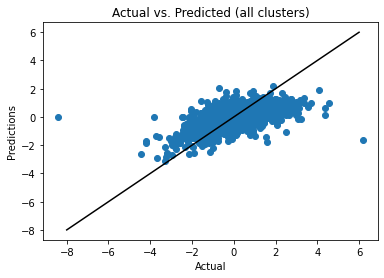

In [285]:
plt.scatter(y_test_stack[np.array(X_test_stack[:,1][:,1] != 0)],np.array(m.predict(np.array(X_test_stack[np.array(X_test_stack[:,1][:,1] != 0)]))).flatten())
plt.title("Actual vs. Predicted (all clusters)")
plt.ylabel("Predictions")
plt.xlabel("Actual")
x = np.linspace(-8,6,100)
plt.plot(x,x, c = "black")
plt.show()

In [287]:
r2_score(np.array(y_test_stack[np.array(X_test_stack[:,1][:,1] != 0)]).flatten(),np.array(m.predict(np.array(X_test_stack[np.array(X_test_stack[:,1][:,1] != 0)]))).flatten())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.3546867775124902

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 0
R^2: 0.37554689865889557
RMSE:0.47911938189481984
MAPE:2.343690698908737
MAE: 0.3720240818885038
sMAPE: 56.557856491849634


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

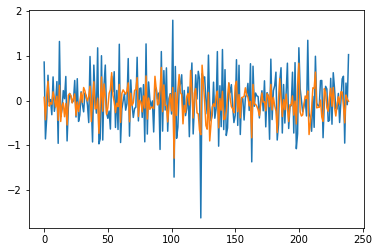

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 1
R^2: 0.38303762806974084
RMSE:0.5415987048498268
MAPE:5.7594927834418606
MAE: 0.4165323280318483
sMAPE: 56.32270453476046


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

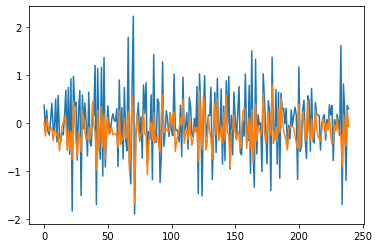

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 2
R^2: 0.13883471562065508
RMSE:0.4444133074392094
MAPE:4.54055430422893
MAE: 0.33809433034016306
sMAPE: 60.20062807986456


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

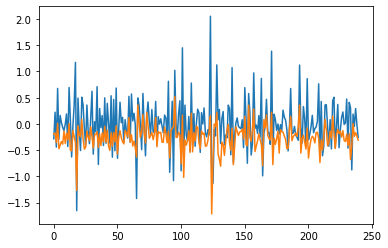

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 3
R^2: 0.31050837157890865
RMSE:0.7940875184623226
MAPE:1.8205157570784432
MAE: 0.6134130429084601
sMAPE: 56.82395187064832


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

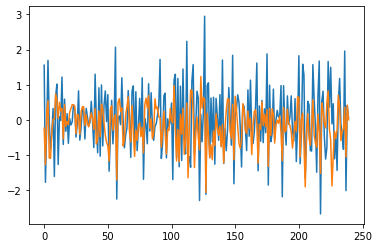

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 4
R^2: 0.41484093009363465
RMSE:0.7116675863529274
MAPE:3.284069909989155
MAE: 0.5614972069726292
sMAPE: 55.866954431894534


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

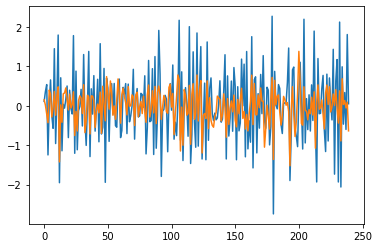

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 5
R^2: 0.4079758573569656
RMSE:0.43655549782465397
MAPE:2.1164499512427826
MAE: 0.3369301290852413
sMAPE: 53.254556091142184


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

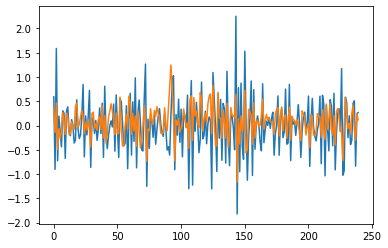

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 6
R^2: 0.35104374232858404
RMSE:0.653065571196984
MAPE:3.164453647818819
MAE: 0.4676766146986277
sMAPE: 59.50117698964827


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

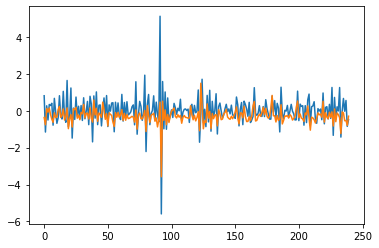

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 7
R^2: 0.21768533011012525
RMSE:1.0173132093414223
MAPE:10.31326602006511
MAE: 0.7182231562483684
sMAPE: 59.5303245617611


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

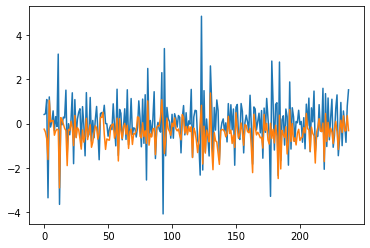

In [302]:
for i in range(8):
    predict(i,m)

In [ ]:
def predict_test(cluster,model):
    s = y_test_stack[cluster][y_test_stack[cluster] != 0].shape[0]
    y_pred = model.predict(np.array(X_test_stack[cluster][y_test_stack[cluster] != 0]).reshape(s,1,80)).flatten()
    y_test = np.array(y_test_stack[cluster][y_test_stack[cluster] != 0]).flatten()
    outstring = f"Cluster: {cluster}\nR^2: {r2_score(y_test,y_pred)}\nRMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}\nMAPE:{mean_absolute_percentage_error(y_test,y_pred)}\n"
    outstring += f"MAE: {mean_absolute_error(y_test,y_pred)}\nsMAPE: {smape(y_test,y_pred)}"
    print(outstring)

    plt.plot(y_test)
    plt.plot(y_pred)
    plt.show()


## Bayesian Hyperparamter Tuning

In [303]:
import kerastuner as kt

In [305]:
def model_builder(hp):
    model = Sequential()
    
    for i in range(hp.Int('LSTM_layers',1,3)):
        model.add(LSTM(hp.Int(f'lstm{i}_units', min_value=10, max_value=80, step=5), return_sequences = True, activation = "tanh"))
        model.add(Dropout(hp.Float(f'lstm{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    for i in range(hp.Int('Dense_layers',1,3)):
        model.add(LSTM(hp.Int(f'dense{i}_units', min_value=5, max_value=65, step=5), return_sequences = True, activation = "tanh"))
        model.add(Dropout(hp.Float(f'dense{i}_dropout', min_value=0, max_value=0.9, step=0.1)))
    
    model.add(Dense(1))
    opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss = 'mse', metrics=['mae'])
    
    return model

In [307]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_mae',
                     max_trials = 100,
                     directory='Modelling/HyperParameterTuning',
                     project_name='LSTM_hp_tuning_new_setup')

In [308]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

<IPython.core.display.Javascript object>

In [309]:
tuner.search(tf.transpose(X_train_stack, perm = [1,0,2]), tf.transpose(y_train_stack, perm = [1,0]), epochs=200 , batch_size=16, validation_data=(tf.transpose(X_val_stack, perm = [1,0,2]), tf.transpose(y_val_stack, perm = [1,0])), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 2 Complete [00h 01m 02s]
val_mae: 0.5911982655525208

Best val_mae So Far: 0.5903632044792175
Total elapsed time: 00h 01m 24s
/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021/env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
LSTM_layers       |2                 |2                 
lstm0_units       |65                |25                
lstm0_dropout     |0.6               |0.9               
Dense_layers      |2                 |1                 
dense0_units      |65                |55                
dense0_dropout    |0.2               |0.8               
learning_rate     |0.00032559        |0.00093029       

KeyboardInterrupt: 

[]

In [34]:
l1 = best_hps.get('lstm1_units')
l2 = best_hps.get('lstm2_units')
d = best_hps.get('dense_units')
print(f"Best HP's\nl1: {l1}\nl2: {l2}\ndense: {d}")

Best HP's
l1: 97
l2: 40
dense: 37


In [57]:
model = tuner.hypermodel.build(best_hps)
history = m_bayes.fit(tf.transpose(X_train_stack, perm = [1,0,2]), tf.transpose(y_train_stack, perm = [1,0]), epochs=100 , batch_size=16, validation_data=(tf.transpose(X_val_stack, perm = [1,0,2]), tf.transpose(y_val_stack, perm = [1,0])))



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/100
138/138 [==============================] - 1s 8ms/step - loss: 0.3431 - mae: 0.3753 - val_loss: 0.2377 - val_mae: 0.2917
Epoch 2/100
138/138 [==============================] - 1s 8ms/step - loss: 0.3166 - mae: 0.3583 - val_loss: 0.2645 - val_mae: 0.3328
Epoch 3/100
138/138 [==============================] - 1s 9ms/step - loss: 0.3368 - mae: 0.3729 - val_loss: 0.2435 - val_mae: 0.3026
Epoch 4/100
138/138 [==============================] - 1s 8ms/step - loss: 0.3189 - mae: 0.3598 - val_loss: 0.2528 - val_mae: 0.2979
Epoch 5/100
138/138 [==============================] - 1s 7ms/step - loss: 0.3201 - mae: 0.3606 - val_loss: 0.2228 - val_mae: 0.2804
Epoch 6/100
138/138 [==============================] - 1s 8ms/step - loss: 0.3219 - mae: 0.3618 - val_loss: 0.2308 - val_mae: 0.2965
Epoch 7/100
138/138 [==============================] - 1s 9ms/step - loss: 0.3120 - mae: 0.3567 - val_loss: 0.2280 - val_mae: 0.2822
Epoch 8/100
138/138 [==============================] - 1s 8ms/step - 

KeyError: 'val_accuracy'

In [60]:
val_mae_per_epoch = history.history['val_mae']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 20


In [39]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

inputs = Input(shape=(None,80))
x = LSTM(97, return_sequences = True, activation = "tanh")(inputs)
x = Dropout(0.2)(x)
x = LSTM(40, return_sequences = True, activation = "tanh")(x)
x = Dropout(0.5)(x)
x = Dense(37, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)

m_bayes = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_model")

m_bayes.compile(optimizer="adam", loss='mse', metrics=["mae"])
m_bayes.fit(tf.transpose(X_train_stack, perm = [1,0,2]), tf.transpose(y_train_stack, perm = [1,0]), epochs=200 , batch_size=16, validation_data=(tf.transpose(X_val_stack, perm = [1,0,2]), tf.transpose(y_val_stack, perm = [1,0])), callbacks=[tensorboard_callback])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/200
138/138 [==============================] - 8s 25ms/step - loss: 1.0461 - mae: 0.6563 - val_loss: 0.9759 - val_mae: 0.5964
Epoch 2/200
138/138 [==============================] - 2s 13ms/step - loss: 1.0538 - mae: 0.6346 - val_loss: 0.9752 - val_mae: 0.5931
Epoch 3/200
138/138 [==============================] - 2s 13ms/step - loss: 0.9985 - mae: 0.6178 - val_loss: 0.9751 - val_mae: 0.5940
Epoch 4/200
138/138 [==============================] - 2s 13ms/step - loss: 1.0222 - mae: 0.6245 - val_loss: 0.9750 - val_mae: 0.5929
Epoch 5/200
138/138 [==============================] - 2s 14ms/step - loss: 0.9691 - mae: 0.6052 - val_loss: 0.9742 - val_mae: 0.5929
Epoch 6/200
138/138 [==============================] - 2s 12ms/step - loss: 1.0437 - mae: 0.6250 - val_loss: 0.9749 - val_mae: 0.5941
Epoch 7/200
138/138 [==============================] - 2s 13ms/step - loss: 1.0132 - mae: 0.6181 - val_loss: 0.9750 - val_mae: 0.5974
Epoch 8/200
138/138 [==============================] - 2s 13ms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

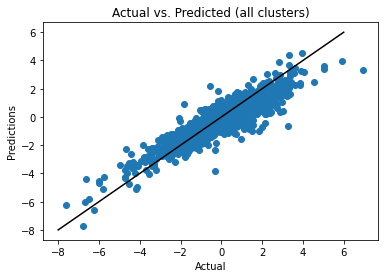

In [40]:
plt.scatter(y_test,np.array(m_bayes.predict(np.array(X_test).reshape(3456,1,80))).flatten())
plt.title("Actual vs. Predicted (all clusters)")
plt.ylabel("Predictions")
plt.xlabel("Actual")
x = np.linspace(-8,6,100)
plt.plot(x,x, c = "black")
plt.show()

In [41]:
r2_score(y_test,np.array(m_bayes.predict(np.array(X_test).reshape(3456,1,80))).flatten())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7869401594704455

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 0
R^2: 0.7688311961370682
RMSE:0.39088225845116387
MAPE:1.7820727052822758
MAE: 0.31040880574665486
sMAPE: 39.49610473871137


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

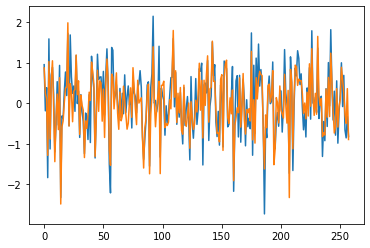

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 1
R^2: 0.8070797475752045
RMSE:0.5167155542183718
MAPE:1.428594168409328
MAE: 0.4053929492279829
sMAPE: 38.212131664857445


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

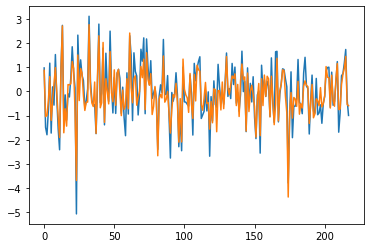

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 2
R^2: 0.7137292237956461
RMSE:0.4423579433408729
MAPE:2.3870967271328323
MAE: 0.3234584594681783
sMAPE: 41.443967853186955


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

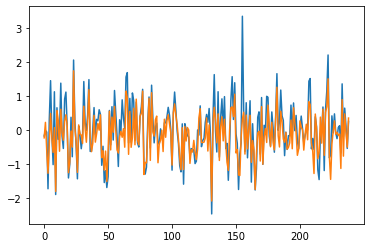

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 3
R^2: 0.7086833280468858
RMSE:1.0264874948561913
MAPE:1.5493138629659786
MAE: 0.7498488010782545
sMAPE: 39.953143374870834


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

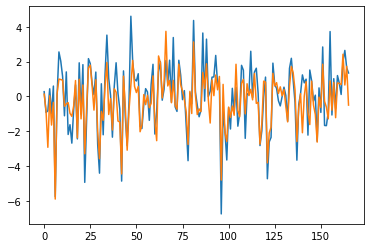

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 4
R^2: 0.8064933827438999
RMSE:0.5678538856634359
MAPE:1.4286582734911109
MAE: 0.4276764083870347
sMAPE: 33.997408417891656


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

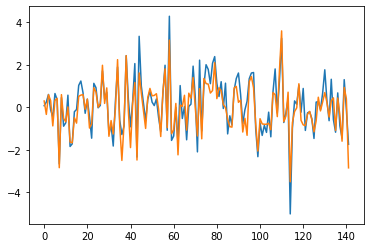

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 5
R^2: 0.7624480018959638
RMSE:0.4618018533091218
MAPE:1.2959849444562828
MAE: 0.3549187159682791
sMAPE: 35.29019165336657


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

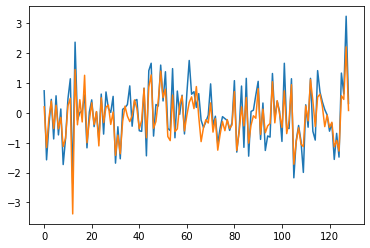

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 6
R^2: 0.7909436645325785
RMSE:0.5569040927303259
MAPE:4.772037465360284
MAE: 0.3948587083255696
sMAPE: 37.7249610859526


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

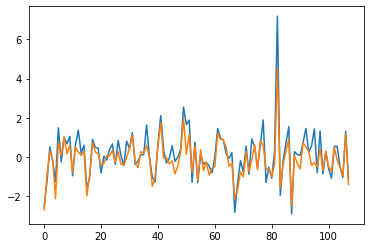

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 7
R^2: 0.8184389268639795
RMSE:0.6193642150707596
MAPE:1.1315723460956852
MAE: 0.466449844340643
sMAPE: 37.94839169221256


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

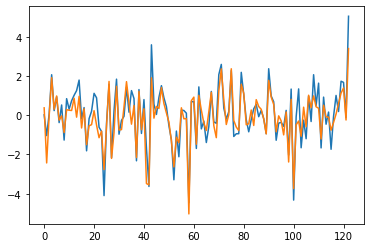

In [42]:
for i in range(8):
    predict(i,m_bayes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 0
R^2: 0.7536196910013206
RMSE:0.433609680387457
MAPE:2.415704984274338
MAE: 0.34051540775319467
sMAPE: 38.36137425916051


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

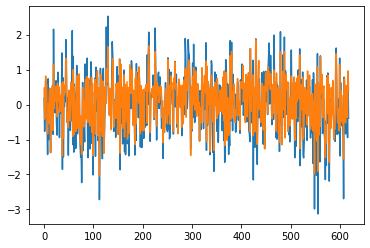

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 1
R^2: 0.7938768513871943
RMSE:0.5429801237821422
MAPE:1.474258050266067
MAE: 0.4051423631294718
sMAPE: 34.67999439146203


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

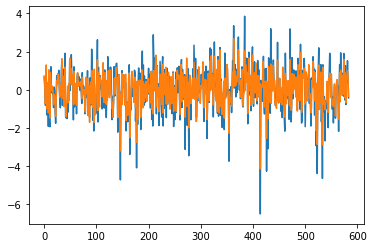

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 2
R^2: 0.7217189891152056
RMSE:0.3981026937794317
MAPE:3.2079480501201734
MAE: 0.31393782986058816
sMAPE: 39.68867915031667


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

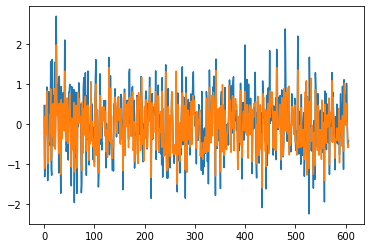

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 3
R^2: 0.7667967636985997
RMSE:0.8763704556598865
MAPE:1.430889139618397
MAE: 0.683807702780437
sMAPE: 40.065411860945


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

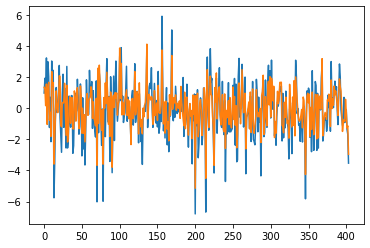

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 4
R^2: 0.7859792921288837
RMSE:0.6627638620844089
MAPE:1.0393531587406744
MAE: 0.4905492019091346
sMAPE: 35.63643770343926


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

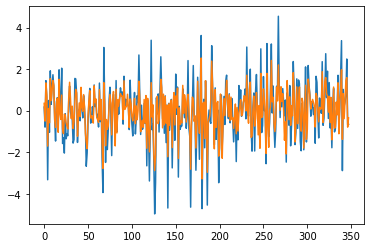

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 5
R^2: 0.7744457213483904
RMSE:0.41960168797064734
MAPE:2.3007039052180502
MAE: 0.32860908850132037
sMAPE: 38.824091222456794


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

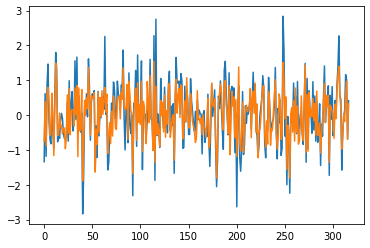

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 6
R^2: 0.7642747832095491
RMSE:0.5359457132485459
MAPE:1.1301230083586433
MAE: 0.3942980892544284
sMAPE: 37.17315072587936


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

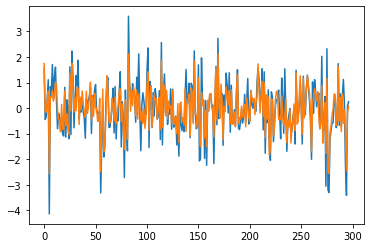

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster: 7
R^2: 0.7888131641077638
RMSE:0.7604316684047385
MAPE:1.2711070141722627
MAE: 0.5355516570506088
sMAPE: 37.14076494167231


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

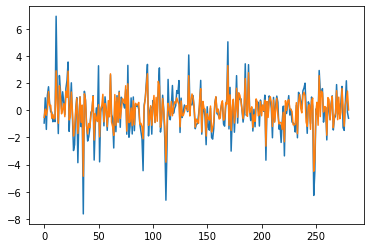

In [36]:
for i in range(8):
    predict_test(i,m_bayes)

## Return to normal

In [90]:
y_pred=np.array(m_bayes.predict(np.array(X_test).reshape(3456,1,80))).flatten()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
first_diff

0.21935985734126962

In [103]:
def createTrue(v, first_diff, first_entry):
    v[1] = first_diff
    v.sort_index()
    v = v.cumsum()
    v[0] = first_entry
    v.sort_index()
    v = v.cumsum()
    
    return v


In [128]:
y_pred_pd = pd.DataFrame(y_pred, index = y_test.index)

<IPython.core.display.Javascript object>

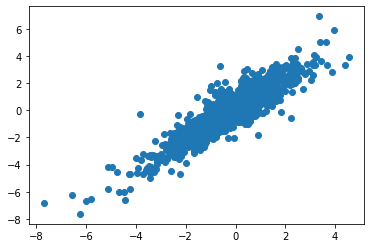

In [130]:
plt.scatter(y_pred_pd.sort_index(),y_test.sort_index())

In [134]:
y_pred_pd.sort_index()

,0
2,-0.476942
5,-0.829702
7,0.434939
10,0.397218
16,0.390050
...,...
17256,-0.185033
17257,-1.927516
17269,-0.865884
17276,3.617634


In [44]:
def predict(cluster,model, test = False):
    if test:
        y_stack = y_test_stack
        X_stack = X_test_stack
    else:
        y_stack = y_val_stack
        X_stack = X_val_stack
    
    true_y_train = createTrue(y_train)
    true_y_test = createTrue(y_test)
    true_y_val = createTrue(y_val)
    print(true_y_test, true_y_train, true_y_val)
    
    
    
   

In [45]:
predict(0,m_bayes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[  1.67988194   1.8992418    2.07013046 ... -76.38278225 -75.73056708
 -76.11867763] [ 1.67988194  1.8992418   2.59070782 ... 42.13544841 42.92664133
 41.39123615] [ 1.67988194  1.8992418   2.64090022 ... 41.05369051 40.23529911
 39.2410147 ]


In [ ]:
 s = y_stack[cluster][y_stack[cluster] != 0].shape[0]
    y_pred = model.predict(np.array(X_stack[cluster][y_stack[cluster] != 0]).reshape(s,1,80)).flatten()
    y_test = np.array(y_stack[cluster][y_stack[cluster] != 0]).flatten()
    outstring = f"Cluster: {cluster}\nR^2: {r2_score(y_test,y_pred)}\nRMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}\nMAPE:{mean_absolute_percentage_error(y_test,y_pred)}\n"
    outstring += f"MAE: {mean_absolute_error(y_test,y_pred)}\nsMAPE: {smape(y_test,y_pred)}"
    print(outstring)

    plt.plot(y_test)
    plt.plot(y_pred)
    plt.show()